<a href="https://colab.research.google.com/github/HimashiRathnayake/Canny-Edge-Detector/blob/main/Canny_Edge_Detection_Algo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Canny Edge Detection Algorithm**

The canny edge detector is an algorithmic
approach that uses a multi-stage process to
detect a wide range of edges in image

Algorithm : 

Step 1 : Convert to Gray Scale

Step 2 : Noise Reduction

Step 3 : Gradient Estimation

Step 4 : Non-maxima Suppression

Step 5 : Double Threshold

#### **Dependencies**

In [1]:
import cv2 as cv
from google.colab.patches import cv2_imshow
import sys
import os
import glob
import numpy as np
import copy

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### **Load Image**

In [3]:
def load_image():
  image_file_path = "/content/drive/Shareddrives/FYP/Images/test.jpg"
  image = cv.imread(image_file_path)
  if image is None:
      sys.exit("Could not read the image.")
  return image

#### **Step 1: Convert to Gray Scale**

In [4]:
# step 1: convert to gray scale

def convert_to_gray_scale(rgb_image):
    r, g, b = rgb_image[:,:,0], rgb_image[:,:,1], rgb_image[:,:,2]
    gray_image = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return gray_image

#### **Apply a Filter**

In [5]:
def apply_filtering(input_image, kernal):

    # print(len(input_image), len(input_image[0]))
    
    output_image = []
    kernal_size = len(kernal)
    kernal_half = kernal_size // 2
    rows_count = len(input_image)
    columns_count = len(input_image[0])

    image_copy = copy.deepcopy(input_image)

    # wrap the image in the edge pixels
    for i in range(rows_count):
      for j in range(kernal_half): 
        image_copy[i].insert(0, input_image[i][-1-j])
        image_copy[i].append(input_image[i][j])
    for i in range(kernal_half):
        image_copy.append(image_copy[2*i])
        image_copy.insert(0, image_copy[-2-2*i].copy())

    # apply filtering
    new_rows_count = len(image_copy)
    new_columns_count = len(image_copy[0])

    for i in range(kernal_half, new_rows_count - kernal_half):
        output_row = []
        for j in range(kernal_half, new_columns_count - kernal_half):
            sum = 0
            for x in range(len(kernal)):
                for y in range(len(kernal)):
                    x1 = i + x - kernal_half
                    y1 = j + y - kernal_half
                    sum += image_copy[x1][y1] * kernal[x][y]
            output_row.append(sum)
        output_image.append(output_row)

    return output_image

#### **Step 2 : Noise Reduction**

In [6]:
# step 2: apply guassian filter for noise reduction

def get_gaussian_kernel(kernal_size, sigma=1):
    gaussian_kernal = np.zeros((kernal_size, kernal_size), np.float32)
    size = kernal_size//2

    for x in range(-size, size+1):
        for y in range(-size, size+1):
            a = 1/(2*np.pi*(sigma**2))
            b = np.exp(-(x**2 + y**2)/(2* sigma**2))
            gaussian_kernal[x+size, y+size] = a*b
    return gaussian_kernal/gaussian_kernal.sum()

#### **Step 3 : Gradient Estimation**

In [7]:
# step 3 : gradient estimation

def gradient_estimate(image, gradient_estimation_filter_type):

  if (gradient_estimation_filter_type=="sobel"):
    Mx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], np.float32)
    My = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], np.float32)
  elif (gradient_estimation_filter_type=="prewitt"):
    Mx = np.array([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]], np.float32)
    My = np.array([[1, 1, 1], [0, 0, 0], [-1, -1, -1]], np.float32)
  else:
    Mx = np.array([[0, 1], [-1, 0]], np.float32)
    My = np.array([[1, 0], [0, -1]], np.float32)

  X = apply_filtering(image, Mx)
  Y = apply_filtering(image, My)

  G = np.hypot(X, Y)
  G = G / G.max() * 255
  theta = np.arctan2(Y, X)
  
  return (G, theta)

#### **Step 4 : Non-maxima Suppression**

In [8]:
# step 4 : non-maxima suppression to thin out the edges

def non_maxima_suppression(image, gradient_direction):
    rows_count = len(image)
    columns_count = len(image[0])

    output_image = np.zeros((rows_count, columns_count), dtype=np.int32)
    theta = gradient_direction * 180. / np.pi
    theta[theta < 0] += 180

    
    for i in range(1, rows_count-1):
        for j in range(1, columns_count-1):
            next = 255
            previous = 255
            if (0 <= theta[i,j] < 22.5) or (157.5 <= theta[i,j] <= 180):
                next = image[i, j+1]
                previous = image[i, j-1]
            elif (22.5 <= theta[i,j] < 67.5):
                next = image[i+1, j-1]
                previous = image[i-1, j+1]
            elif (67.5 <= theta[i,j] < 112.5):
                next = image[i+1, j]
                previous = image[i-1, j]
            elif (112.5 <= theta[i,j] < 157.5):
                next = image[i-1, j-1]
                previous = image[i+1, j+1]

            if (image[i,j] >= next) and (image[i,j] >= previous):
                output_image[i,j] = image[i,j]
            else:
                output_image[i,j] = 0
    
    return output_image

#### **Step 5 : Double Threshold**

In [9]:
def double_threshold(image, low_threshold_ratio, high_threshold_ratio):
    
    high_threshold = image.max() * high_threshold_ratio;
    low_threshold = high_threshold * low_threshold_ratio;
    
    rows_count = len(image)
    columns_count = len(image[0])
    output_image = np.zeros((rows_count, columns_count), dtype=np.int32)
    
    weak = np.int32(25)
    strong = np.int32(255)

    strong_i = []
    strong_j = []
    weak_i = [] 
    weak_j = []
    for i in range (len(image)):
      for j in range (len(image[0])):
        if (image[i,j]>=high_threshold):
          strong_i.append(i)
          strong_j.append(j)
        if ((image[i,j] <= high_threshold) & (image[i,j] >= low_threshold)):
          weak_i.append(i)
          weak_j.append(j)
    strong_i = np.array(strong_i)
    strong_j = np.array(strong_j)
    weak_i = np.array(weak_i)
    weak_j = np.array(weak_j)
    
    output_image[strong_i, strong_j] = strong
    output_image[weak_i, weak_j] = weak


    
    return (output_image, weak, strong)

In [10]:
def hysteresis(img, weak, strong=255):
    M, N = img.shape  
    for i in range(1, M-1):
        for j in range(1, N-1):
            if (img[i,j] == weak):
                try:
                    if ((img[i+1, j-1] == strong) or (img[i+1, j] == strong) or (img[i+1, j+1] == strong)
                        or (img[i, j-1] == strong) or (img[i, j+1] == strong)
                        or (img[i-1, j-1] == strong) or (img[i-1, j] == strong) or (img[i-1, j+1] == strong)):
                        img[i, j] = strong
                    else:
                        img[i, j] = 0
                except IndexError as e:
                    pass
    return img

In [16]:
def apply_canny_edge_detection(kernal_size = 3, low_threshold_ratio = 0.05, high_threshold_ratio = 0.09, gradient_estimation_filter_type = "sobel"):

  # load image
  image = load_image()
  print("Original Image : ")
  cv2_imshow(image)

  # step 1 : convert image to gray scale
  gray_scaled_image = convert_to_gray_scale(image)
  print("\nGray Scaled Image : ")
  cv2_imshow(gray_scaled_image)

  # step 2 : apply gaussian kernal to filter noise
  kernal = get_gaussian_kernel(kernal_size)
  image_without_noise = apply_filtering(gray_scaled_image.tolist(), kernal)
  print("\nImage Without Noise : ")
  cv2_imshow(np.array(image_without_noise))

  # step 3 : gradient estimation
  assert (gradient_estimation_filter_type in ["sobel", "prewitt", "robert"]), "gradient estimation filter type should be [\"prewitt\", \"sobel\", \"robert\"]"
  G, theta = gradient_estimate(image_without_noise, gradient_estimation_filter_type)
  print("\nImage After Gradient Estimation : ")
  cv2_imshow(np.array(G))

  # step 4 : non maxima suppression
  image_with_thin_edges = non_maxima_suppression(G, theta)
  print("\nImage After Non-Maxima Suppression : ")
  cv2_imshow(np.array(image_with_thin_edges))

  # step 5 : double threshold
  final_image, weak, strong = double_threshold(image_with_thin_edges, low_threshold_ratio, high_threshold_ratio)
  print("\nImage After Apply Double Threshold : ")
  cv2_imshow(np.array(final_image))

  img = hysteresis(final_image, weak, strong=255)
  print("\nFinalImage")
  cv2_imshow(np.array(img))

  return

Original Image : 


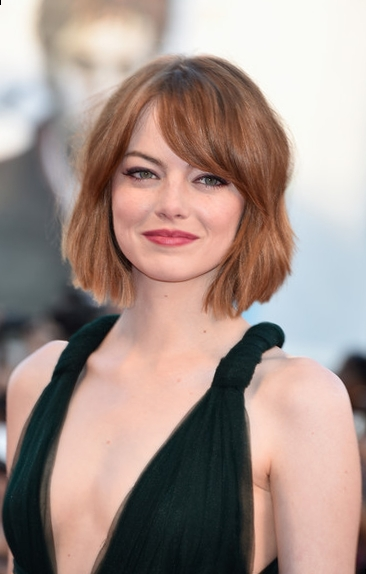


Gray Scaled Image : 


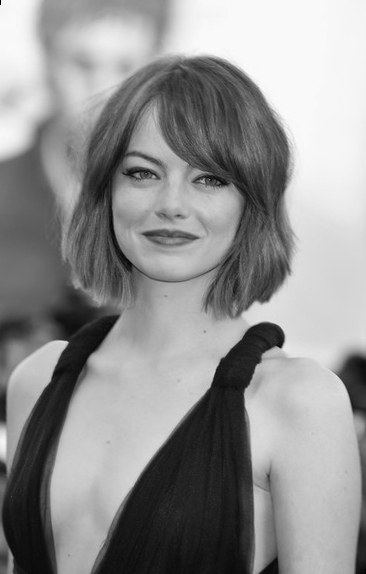


Image Without Noise : 


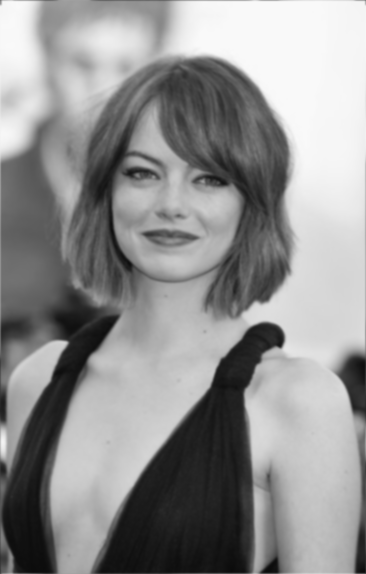


Image After Gradient Estimation : 


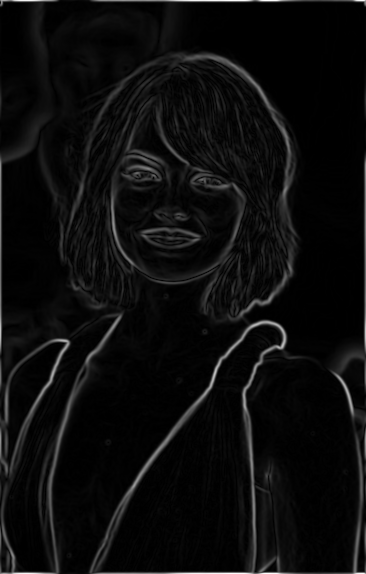


Image After Non-Maxima Suppression : 


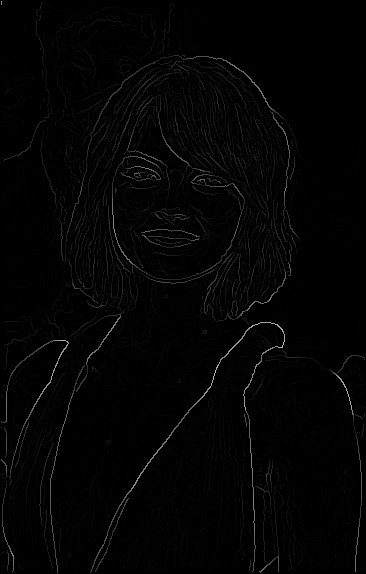


Image After Apply Double Threshold : 


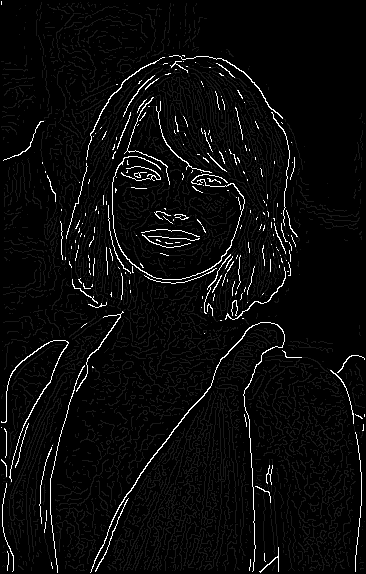


FinalImage


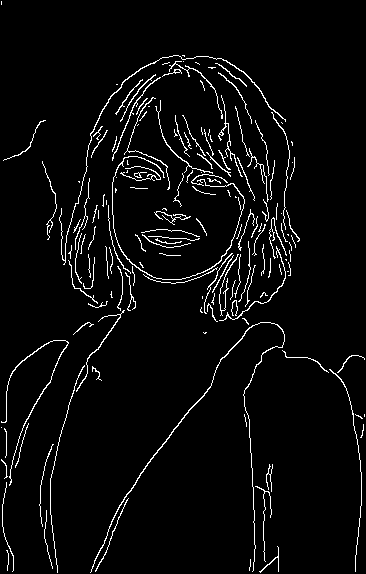

In [17]:
apply_canny_edge_detection(kernal_size=5, low_threshold_ratio = 0.05, high_threshold_ratio = 0.15, gradient_estimation_filter_type="sobel")